<a href="https://colab.research.google.com/github/Koushikgoud/GCN-ML-Intro/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1

In [4]:
import stellargraph as sg 

try:
  sg.utils.validate_notebook_version("1.0.0rc1")
except AttributeError:
  raise ValueError(
      f"This notebook requires StellarGraph version 1.0.0rc1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
  ) from None


In [5]:
import pandas as pd
import os
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

In [ ]:
node_subjects.value_counts().to_frame()

In [13]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
train_subjects.value_counts().to_frame()

In [20]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)


In [ ]:
generator = FullBatchNodeGenerator(G, method = "gcn")

In [24]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [25]:
gcn = GCN(
    layer_sizes = [16, 16], activations = ["relu", "relu"], generator = generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()
x_out

In [29]:
predictions = layers.Dense(units=train_targets.shape[1], activation = "softmax")(x_out)

In [32]:
model = Model(inputs = x_inp, outputs = predictions)
model.compile(
    optimizer = optimizers.Adam(learning_rate=0.01),
    loss = losses.categorical_crossentropy,
    metrics = ["acc"],
)

In [33]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [36]:
history = model.fit(
    train_gen,
    epochs = 200,
    validation_data = val_gen,
    verbose = 2,
    shuffle = False,
    callbacks = [es_callback],

)

Epoch 1/200
1/1 - 2s - loss: 1.9453 - acc: 0.1286 - val_loss: 1.9002 - val_acc: 0.3480 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.8946 - acc: 0.2929 - val_loss: 1.8578 - val_acc: 0.3500 - 142ms/epoch - 142ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8427 - acc: 0.3571 - val_loss: 1.8046 - val_acc: 0.3220 - 132ms/epoch - 132ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7513 - acc: 0.3714 - val_loss: 1.7419 - val_acc: 0.3260 - 140ms/epoch - 140ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6899 - acc: 0.3214 - val_loss: 1.6762 - val_acc: 0.3420 - 125ms/epoch - 125ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5951 - acc: 0.3929 - val_loss: 1.6076 - val_acc: 0.3600 - 123ms/epoch - 123ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4992 - acc: 0.4429 - val_loss: 1.5371 - val_acc: 0.3940 - 126ms/epoch - 126ms/step
Epoch 8/200
1/1 - 0s - loss: 1.4211 - acc: 0.4857 - val_loss: 1.4652 - val_acc: 0.4400 - 123ms/epoch - 123ms/step
Epoch 9/200
1/1 - 0s - loss: 1.3046 - acc: 0.5429 - val_loss: 1.3909 - val_acc: 0.4780 - 134ms

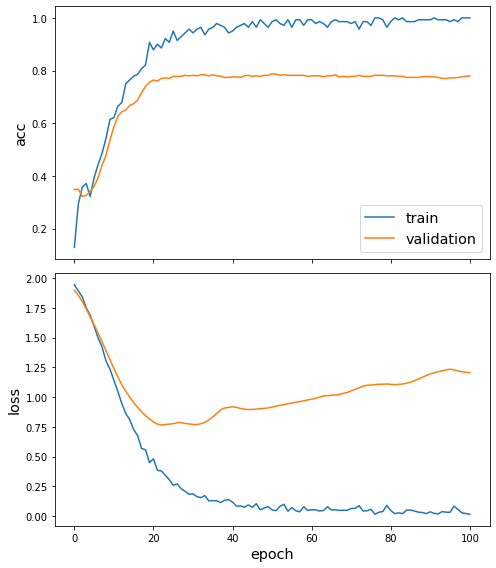

In [37]:
sg.utils.plot_history(history)

In [39]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [41]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
  print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 188ms/step - loss: 0.8848 - acc: 0.8056

Test Set Metrics:
	loss: 0.8848
	acc: 0.8056


In [42]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)


1/1 [==============================] - 0s 192ms/step


In [44]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [48]:
df = pd.DataFrame({"Predicted":node_predictions, "True":node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


In [49]:
embedding_model = Model(inputs=x_inp, outputs = x_out)
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 0s 238ms/step


(1, 2708, 16)

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
transform = PCA

In [60]:
# emb = emb.squeeze(0)
emb.shape

(2708, 16)

In [62]:
# from sklearn import transform
trans = transform(n_components = 2)
emb_reduced = trans.fit_transform(emb)
emb_reduced.shape

(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'PCA visualization of GCN embeddings for Cora dataset'),
 None]

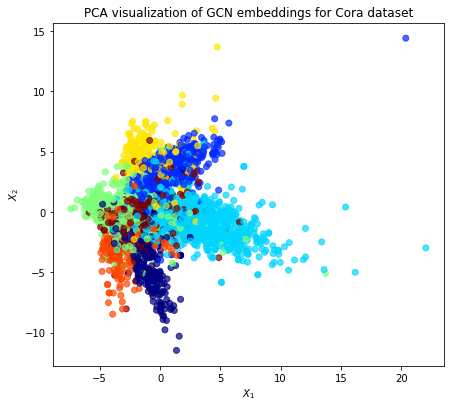

In [63]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(
    emb_reduced[:,0],
    emb_reduced[:,1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)

ax.set(
    aspect = "equal",
    xlabel = "$X_1$",
    ylabel = "$X_2$",
    title = f"{transform.__name__} visualization of GCN embeddings for Cora dataset"
)